In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib  # For saving the model





In [5]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

In [6]:
# Data overview
print("\nDataset Shape:", data.shape)
print("\nFirst 5 rows:\n", data.head())
print("\nBasic Statistics:\n", data.describe())



Dataset Shape: (768, 9)

First 5 rows:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Basic Statistics:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.36

In [7]:
# Replace zeros with NaN for specific columns
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_to_replace] = data[columns_to_replace].replace(0, np.nan)

In [8]:
# Handle missing values by imputation (median strategy)
data[columns_to_replace] = data[columns_to_replace].fillna(data[columns_to_replace].median())

In [9]:
# Check for class imbalance
print("\nTarget Class Distribution:\n", data['Outcome'].value_counts())


Target Class Distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [10]:
# Define features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("\nBalanced Target Class Distribution:\n", pd.Series(y_resampled).value_counts())


Balanced Target Class Distribution:
 Outcome
1    500
0    500
Name: count, dtype: int64


In [13]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

In [17]:
# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.73
ROC-AUC Score: 0.8241824182418241
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72        99
           1       0.73      0.74      0.74       101

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200


Training Random Forest...
Random Forest Performance:
Accuracy: 0.78
ROC-AUC Score: 0.877987798779878
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77        99
           1       0.76      0.83      0.79       101

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


Training XGBoost...
XGBoost Performance:
Accuracy: 0.775
ROC-AUC Score: 0.854985

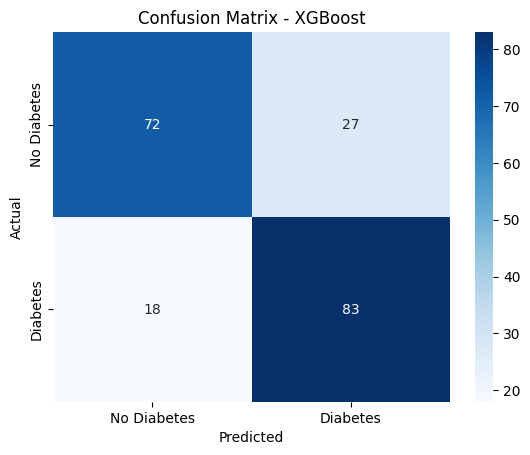

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(models['XGBoost'], param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2, refit=True) # Add refit=True
grid_search.fit(X_train, y_train)

print("\nBest Parameters for XGBoost:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [26]:
# Save the best model
joblib.dump(best_model, 'diabetes_prediction_model.pkl')
print("\nModel saved as 'diabetes_prediction_model.pkl'.")


Model saved as 'diabetes_prediction_model.pkl'.
